# Dr Rahman Farnoosh

## Erfan Janfaza


# Quickprop: an almost forgotten neural training algorithm

Standard Back-propagation is probably the best neural training algorithm for shallow and deep networks, however, it is based on the chain rule of derivatives and an update in the first layers requires a knowledge back-propagated from the last layer. This non-locality, especially in deep neural networks, reduces the biological plausibility of the model because, even if there’s enough evidence of negative feedback in real neurons, it’s unlikely that, for example, synapsis in LGN (Lateral Geniculate Nucleus) could change their dynamics (weights) considering a chain of changes starting from the primary visual cortex. Moreover, classical back-propagation doesn’t scale very well in large networks.

For these reasons, in 1988 Fahlman proprosed an alternative local and quicker update rule, where the total loss function L is approximated with a quadratic polynomial function (using Taylor expansion) for each weight independently (assuming that each update has a limited influence on the neighbors). The resulting weight update rule (which is a pseudo-second-order method) is:

 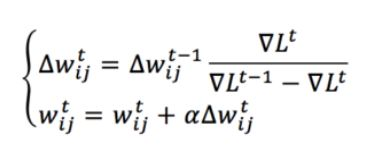
 
 L is the cost function (total loss function) and the gradient must be computed according to the connection between neuron i (belonging to a higher layer) and neuron j (belonging to a lower layer): ∇L(i,j), while alpha is the learning rate. This rule is completely local (because it depends only on the information gathered from the pre- and post-synaptic units) and can also be very fast when the problem is convex but, on the other side, has some heavy drawbacks:

It needs to store the previous gradient and weight correction (this is partially biologically plausible)
It can produce “uncertain” jumps when the error surface has many local minima, due to the approximation of the loss function and its second derivative
For these reasons, this algorithm has been almost abandoned in favor of Back-propagation that, together with the most common optimizers, like RMSProp or Adam, can reach the convergence in very deep networks without particular drawbacks.

In [2]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt

# Set random seed (for reproducibility)
np.random.seed(1000)

def sigmoid(arg):
    return 1.0 / (1.0 + np.exp(-arg))

# Create random dataset
nb_samples = 500
nb_features = 2

X, Y = make_classification(n_samples=nb_samples, 
                           n_features=nb_features, 
                           n_informative=nb_features, 
                           n_redundant=0, 
                           random_state=4)
X.shape,Y.shape,Y

((500, 2),
 (500,),
 array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


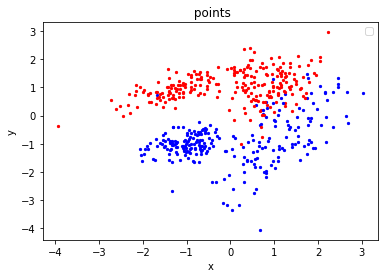

In [2]:

plt.legend()
xx=X[:,0]
yy=X[:,1]
for i in range(500):
    if Y[i]==0:
        plt.scatter(xx[i],yy[i],s=5,marker="o", color='blue') 
    else:
        plt.scatter(xx[i],yy[i],s=5,marker="o", color='red')
        
plt.title( ' points' )
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For simplicity, the X dataset has been transformed into a (N, 3) matrix, with the third column equal to 1. In this way, the bias can be learned just like any other weight. The cost function based on the cross-entropy is:
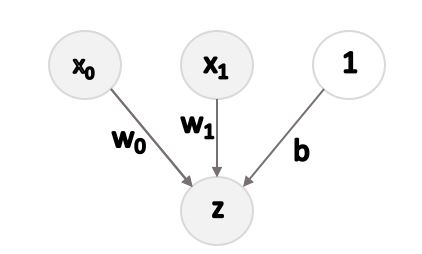

and 


In [3]:
# Prepreprocess the dataset
Xt = np.ones(shape=(nb_samples, nb_features+1))
Xt[:, 0:2] = X
Yt = Y.reshape((nb_samples, 1))
Xt

array([[-0.32898741, -0.46866055,  1.        ],
       [ 0.97519373, -1.2293884 ,  1.        ],
       [ 1.92176805, -1.16322071,  1.        ],
       ...,
       [-1.68437925,  0.84924399,  1.        ],
       [-0.99254187, -1.25253175,  1.        ],
       [-1.66243578,  1.19105519,  1.        ]])

In [4]:
# Initial values
W = np.random.uniform(-0.01, 0.01, size=(1, nb_features+1))
dL = np.zeros((1, nb_features + 1))
dL_prev = np.random.uniform(-0.001, 0.001, size=(1, nb_features + 1))
dW_prec = np.ones((1, nb_features + 1))
W_prev = np.zeros((1, nb_features + 1))

learning_rate = 0.0001
tolerance = 1e-6

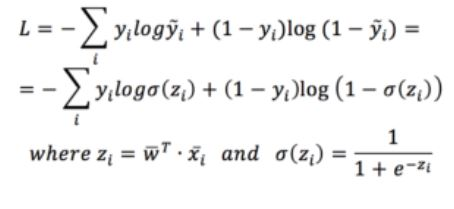

In [5]:
# Run a training process
i = 0

while np.linalg.norm(W_prev - W, ord=1) > tolerance:
    i += 1
    
    sZ = sigmoid(np.dot(Xt, W.T))
    
    dL = np.sum((Yt - sZ) * Xt, axis=0)
    delta = dL / (dL_prev - dL)
    dL_prev = dL.copy()
    
    dW = dW_prec * delta
    dW_prec = dW.copy()
    
    W_prev = W.copy()
    W += learning_rate * dW
    
    print('Converged after {} iterations'.format(i))

Converged after 1 iterations
Converged after 2 iterations
Converged after 3 iterations
Converged after 4 iterations
Converged after 5 iterations
Converged after 6 iterations
Converged after 7 iterations
Converged after 8 iterations
Converged after 9 iterations
Converged after 10 iterations
Converged after 11 iterations
Converged after 12 iterations
Converged after 13 iterations
Converged after 14 iterations
Converged after 15 iterations
Converged after 16 iterations
Converged after 17 iterations
Converged after 18 iterations
Converged after 19 iterations
Converged after 20 iterations
Converged after 21 iterations
Converged after 22 iterations
Converged after 23 iterations
Converged after 24 iterations
Converged after 25 iterations
Converged after 26 iterations
Converged after 27 iterations
Converged after 28 iterations
Converged after 29 iterations
Converged after 30 iterations
Converged after 31 iterations
Converged after 32 iterations
Converged after 33 iterations
Converged after 34 